# Analysis of OSM at the municipal level

This notebook explores the quality of OSM data, based on the results from running BikeDNA BIG, at the municipal level.

The notebook indexes the data aggregated at the grid level by municipality and computes a number of metrics such as municipal infrastructure density, density per 1000 people, components and topology errors compared to infrastructure length and density, etc.

For required data sets, see the README for this repository.

Results are saved to subfolders in the `results/osm_analysis/[study_area]/` folder.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import pandas as pd

from src import evaluation_functions as eval_func

%run ../settings/yaml_variables.py
%run ../settings/df_styler.py
%run ../settings/plotting.py
%run ../settings/load_osmdata.py
%run ../settings/paths.py


/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/opt/miniconda3/envs/bikedna_analysis/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


OSM data loaded successfully!


In [2]:
# Read intrinsic grid results
with open(
    f"../results/osm/{study_area}/data/grid_results_intrinsic.pickle", "rb"
) as fp:
    osm_intrinsic_grid = pickle.load(fp)

# Import intrinsic results
osm_intrinsic_file = open(
    f"../results/osm/{study_area}/data/intrinsic_analysis.json"
)

osm_intrinsic_results = json.load(osm_intrinsic_file)

# Import summary dataframe
summarize_results_df = pd.read_csv(f"../results/osm/{study_area}/data/intrinsic_summary_results.csv",index_col=0)

summarize_results_df.style.pipe(format_osm_style)

,
Total infrastructure length (km),"20,681"
Protected bicycle infrastructure density (m/km2),386
Unprotected bicycle infrastructure density (m/km2),60
Mixed protection bicycle infrastructure density (m/km2),1
Bicycle infrastructure density (m/km2),446
Nodes,"90,804"
Dangling nodes,"46,426"
Nodes per km2,2
Dangling nodes per km2,1
Incompatible tag combinations,37


## Municipal Analysis

In [3]:
# Read muni data
muni = gpd.read_file(muni_polygons_fp)

# If another data set is used, update the original columns names here
# Assumes a unique name and id column.
rename_dict = {"navn":"name",
               "kommunekode":"municipal_id"}

muni.rename(rename_dict,axis=1,inplace=True)

muni = muni[["name",'municipal_id','geometry']] 
assert muni.crs == study_crs

**Assign municipal ID/name to all grid cells**

In [4]:
# Assign municipal name and id to each hex cell based on centroid overlap
osm_intrinsic_grid.dropna(subset='count_osm_edges',inplace=True)

grid_centroids = osm_intrinsic_grid[['geometry','grid_id','count_osm_edges']].copy()
grid_centroids['geometry'] = grid_centroids.geometry.centroid

joined_int_grid = eval_func.index_by_muni(grid_centroids, muni)

int_grid = osm_intrinsic_grid.merge(joined_int_grid[['grid_id',"name",'municipal_id']],left_on='grid_id',right_on='grid_id')
assert len(int_grid) == len(osm_intrinsic_grid)


**Index nodes and edges by municipality**

In [5]:
# Index nodes and edges by municipality
muni_edges = eval_func.index_by_muni(osm_edges_simplified, muni, assert_len=False)

muni_nodes = eval_func.index_by_muni(osm_nodes_simplified, muni, assert_len=True, drop_dupli=True, dupli_id='osmid')
assert len(muni_nodes) == len(muni_nodes.osmid.unique())

# Index dangling nodes by muni
muni_dang = eval_func.index_by_muni(osm_dangling, muni, assert_len=True, drop_dupli=True, dupli_id='osmid')
assert len(muni_dang) == len(muni_dang.osmid.unique())


# Recompute infrastructure length
muni_edges["infrastructure_length"] = muni_edges.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

# Group by muni
grouped_edges = muni_edges.groupby("name") 
grouped_nodes = muni_nodes.groupby("name")
grouped_dangling = muni_dang.groupby("name")

# Turn into dataframe
muni_infra = grouped_edges['infrastructure_length'].sum().to_frame()

muni_node_count = grouped_nodes.size().to_frame('node_count') 

muni_dang_count = grouped_dangling.size().to_frame('dangling_node_count') 

muni_network_counts = pd.merge(pd.merge(muni_infra, muni_node_count,left_index=True, right_index=True),muni_dang_count,left_index=True, right_index=True)

assert len(muni_network_counts) == 98

**Plot length of bicycle infrastructure, bicycle infrastructure density and infrastructure per 1000 people**

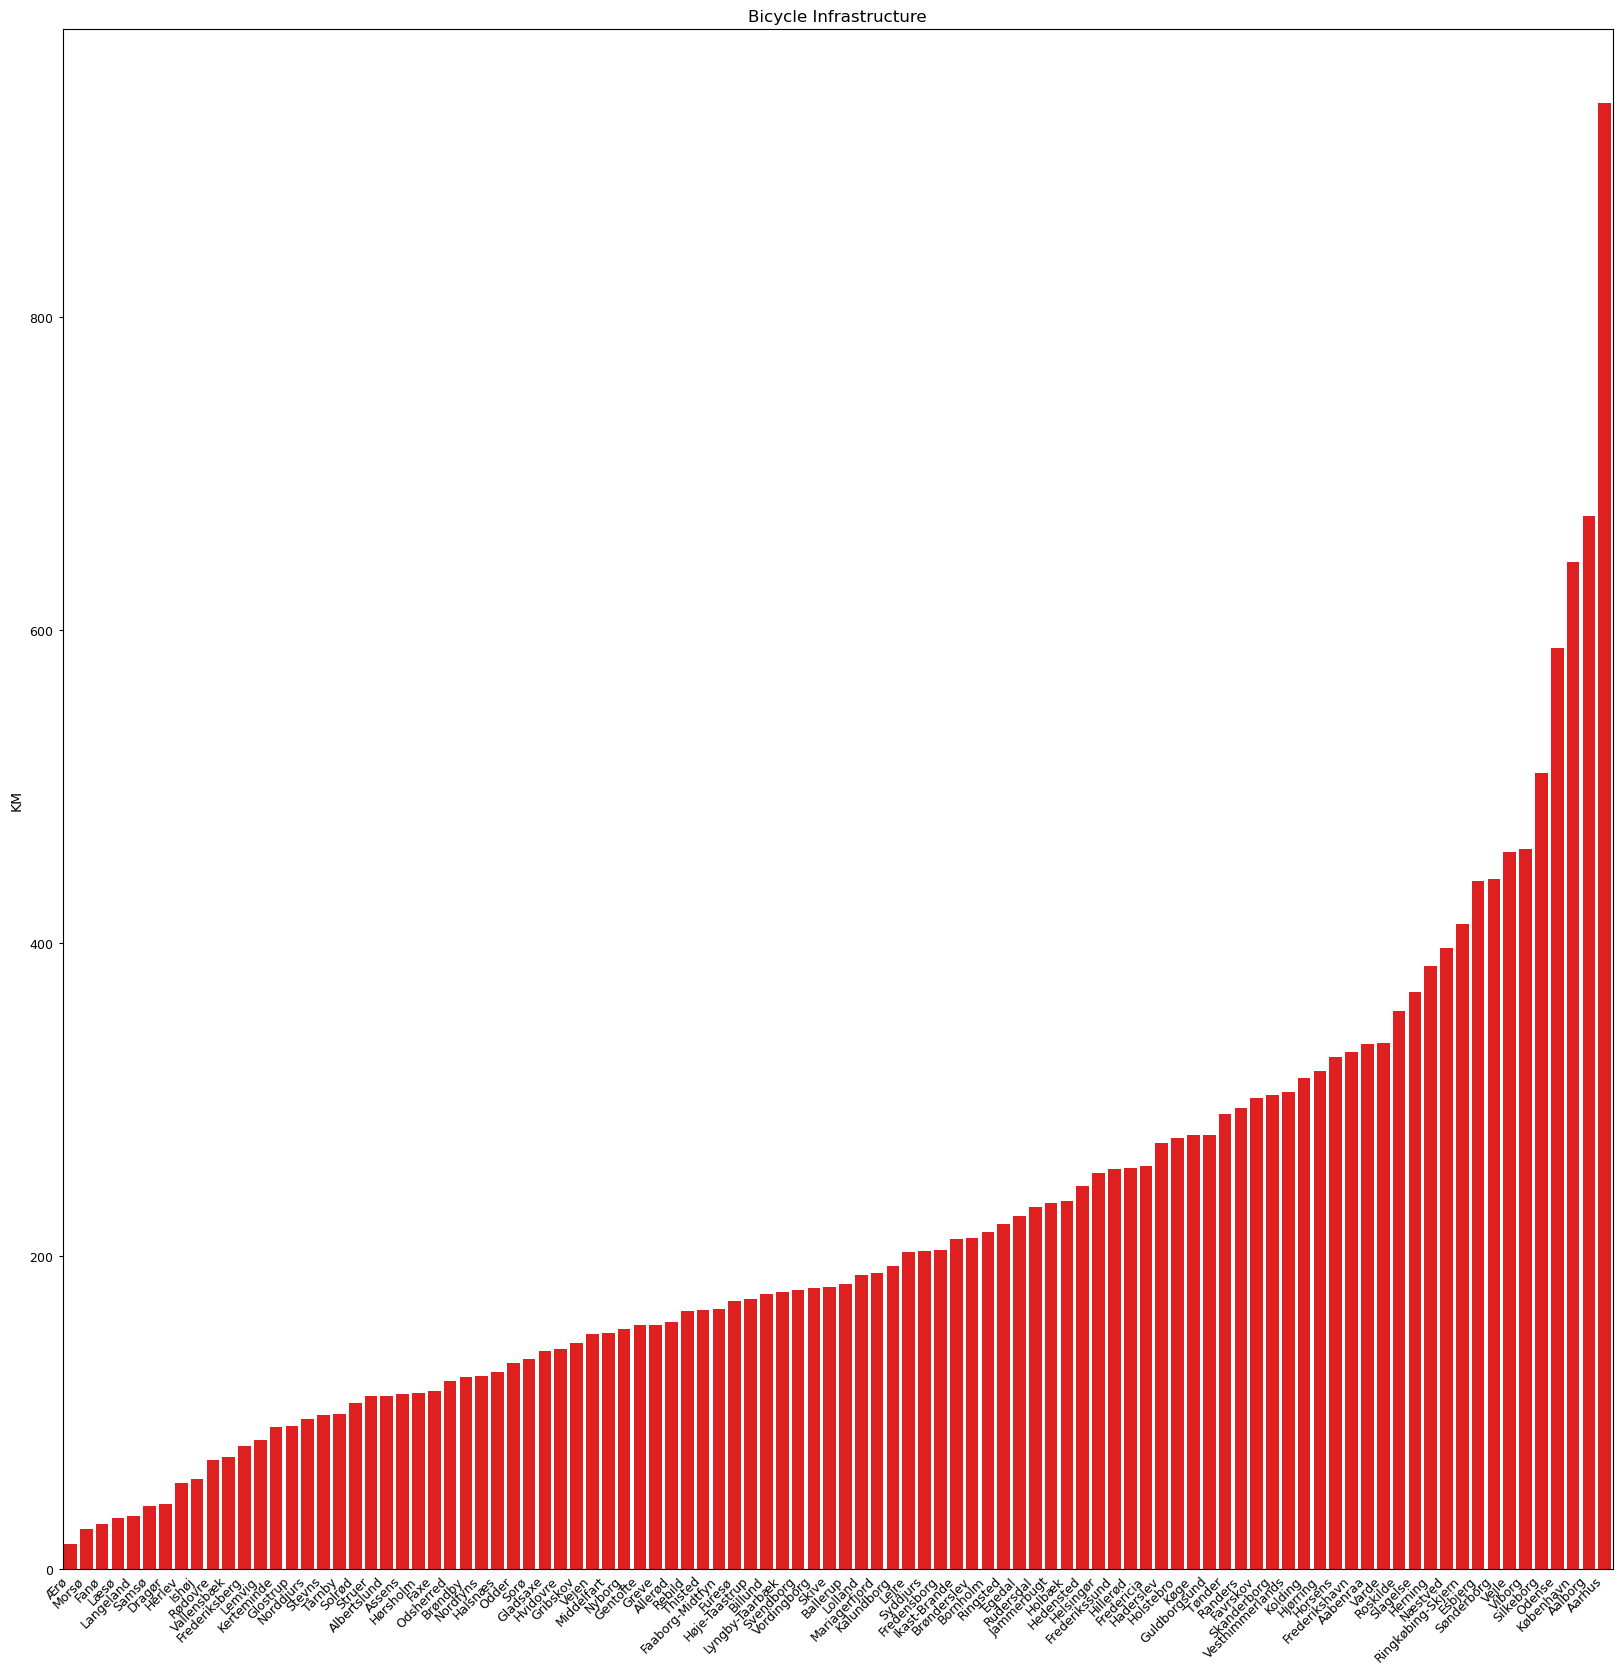

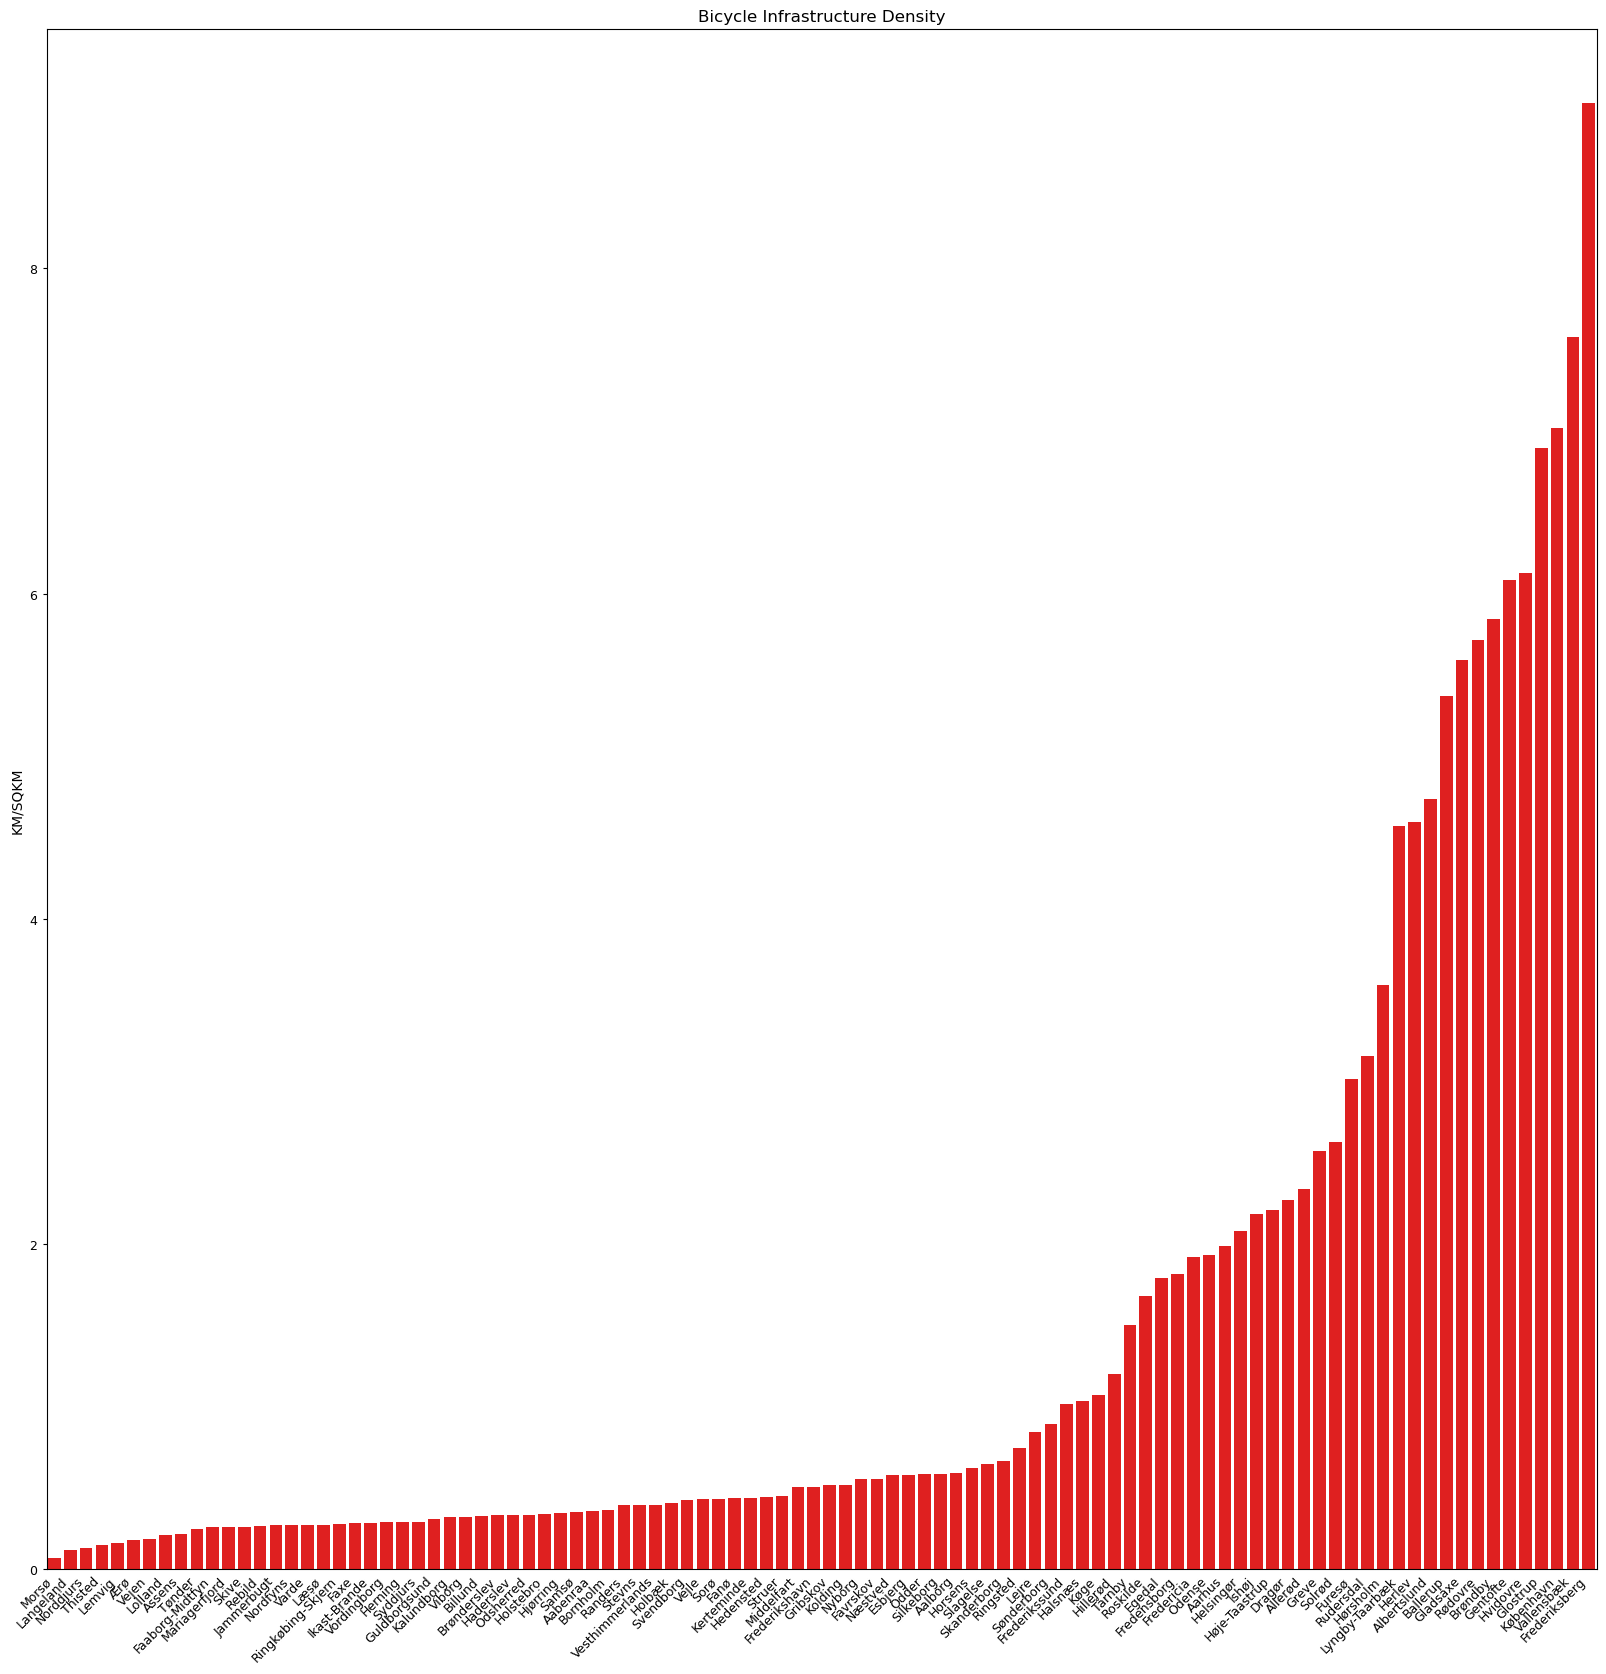

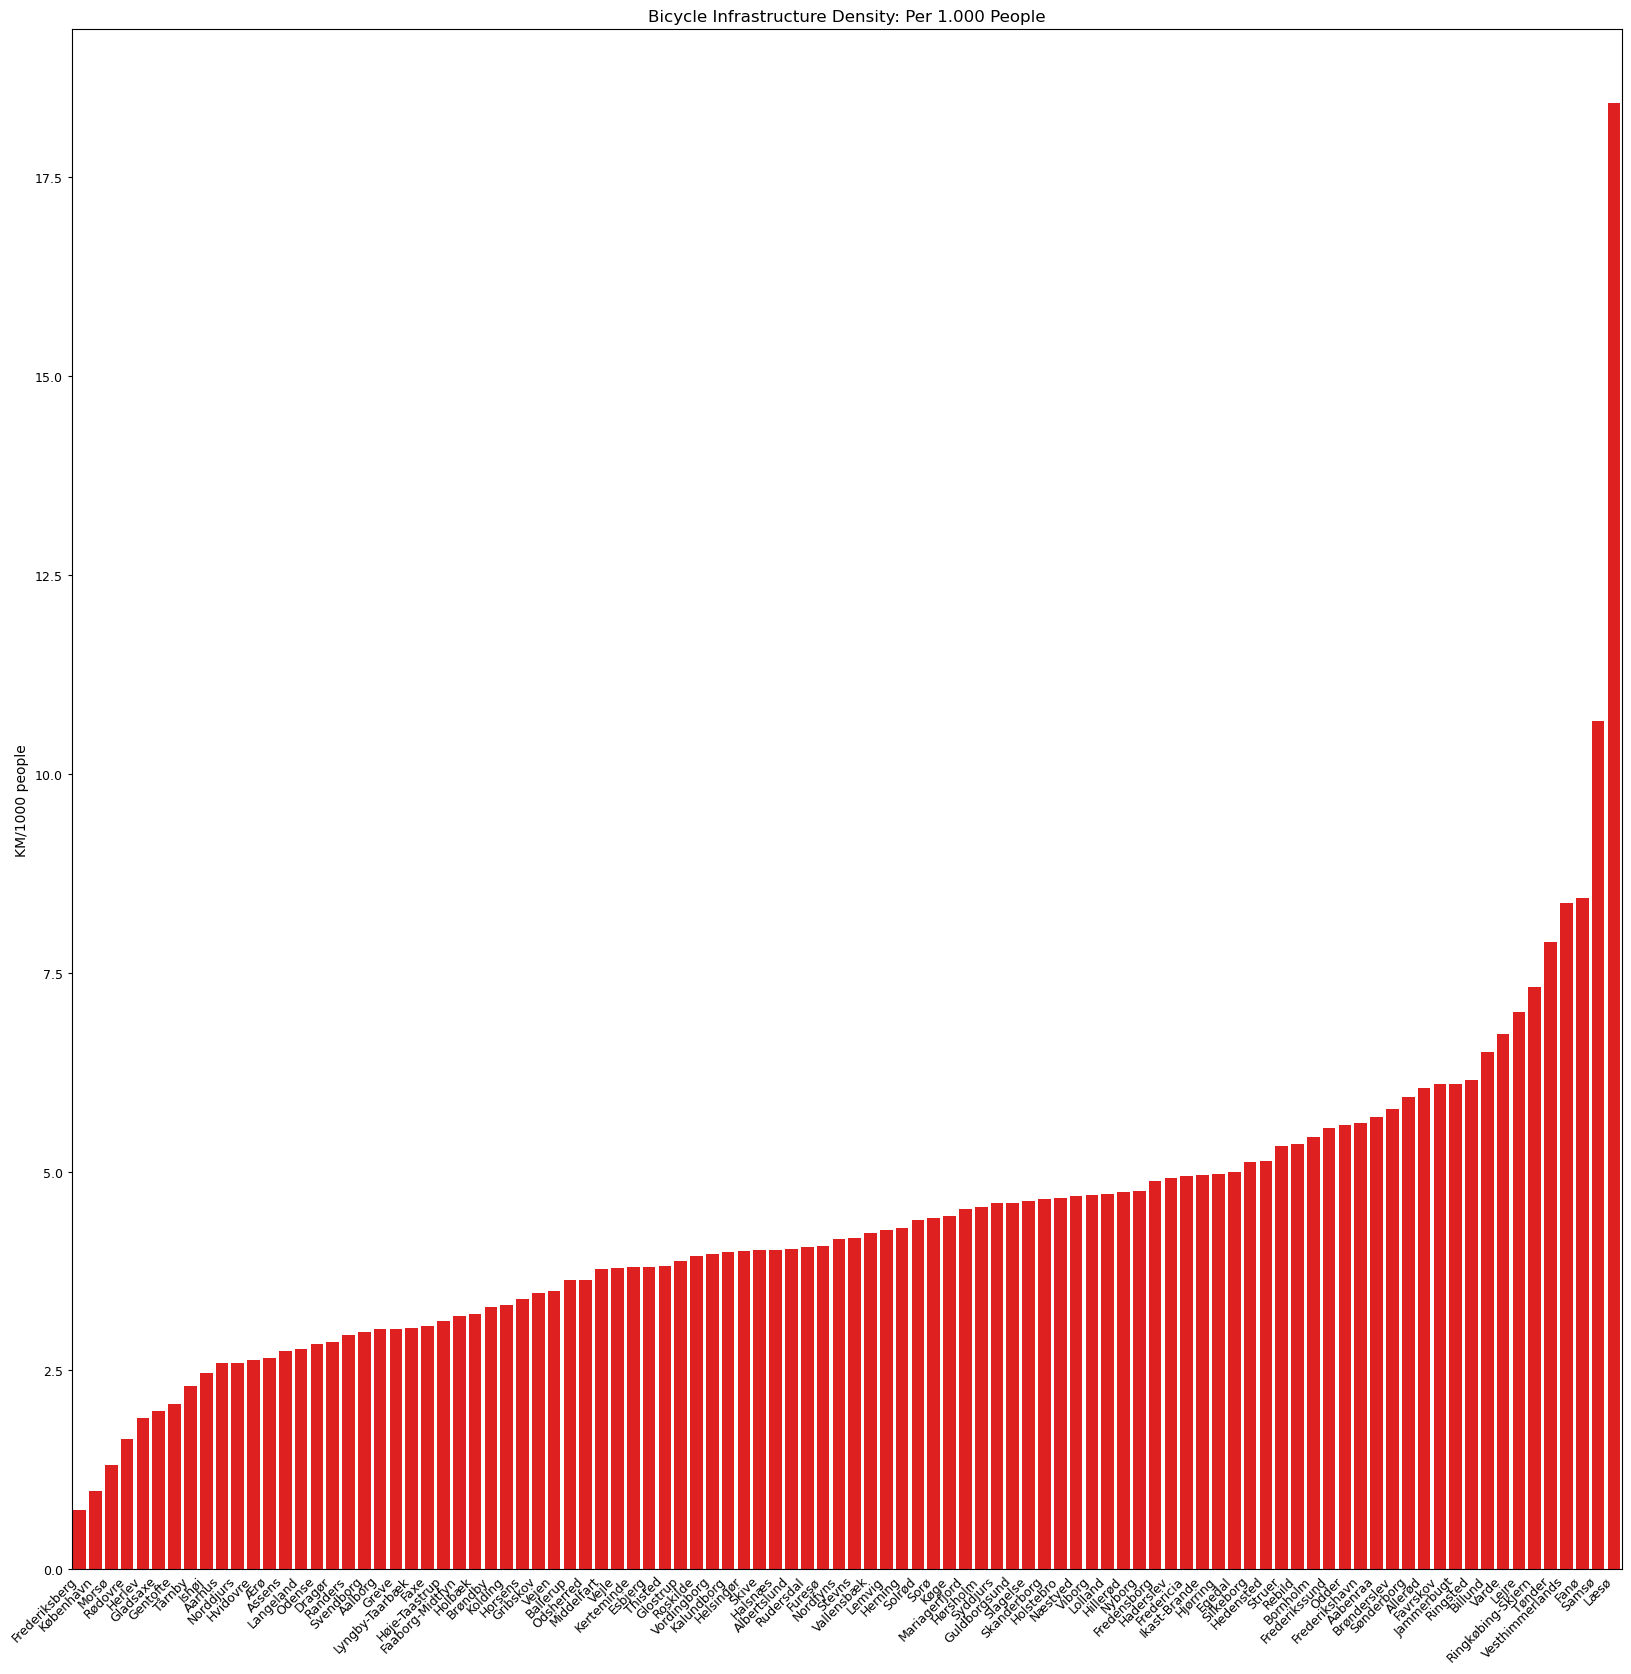

In [6]:
# Plot km of bicycle infra per muni
muni_network_counts['infra_km'] = round(muni_network_counts.infrastructure_length / 1000,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_km'), x="name",y='infra_km',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM')
plt.title('Bicycle Infrastructure');

# Plot infra density per muni
muni['area_sqkm'] = round(muni.area / 1000000,2)

muni_network_counts = muni_network_counts.merge(
    muni[["name",'area_sqkm']],left_index=True,right_on="name"
)

muni_network_counts['infra_dens'] = round(muni_network_counts.infra_km / muni_network_counts.area_sqkm,3)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_dens'), x="name",y='infra_dens',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/SQKM')
plt.title('Bicycle Infrastructure Density');

# Plot infra per pop
muni_pop = pd.read_csv(muni_pop_fp,encoding="ISO-8859-1",header=None)
muni_pop.rename({1:"name",2:'pop'},inplace=True,axis=1)

muni_network_counts = muni_network_counts.merge(muni_pop[["name",'pop']],left_on="name", right_on="name")
assert len(muni_network_counts) == 98

muni_network_counts['infra_pop'] = muni_network_counts.infra_km / (muni_network_counts['pop'] / 1000)

fig, ax = plt.subplots(figsize=(20,20))
sns.barplot(muni_network_counts.reset_index().sort_values('infra_pop'), x="name",y='infra_pop',ax=ax, color='red')
plt.xticks(rotation = 45, ha = 'right')
plt.xlabel('')
plt.ylabel('KM/1000 people')
plt.title('Bicycle Infrastructure Density: Per 1.000 People');

**Index over and undershoots by municipality**

In [7]:
# Join over and undershoot to muni
overshoot_edge_ids = pd.read_csv(osm_results_data_fp+"overshoot_edges_3.csv")
undershoot_node_ids = pd.read_csv(osm_results_data_fp+"undershoot_nodes_3.csv")

undershoots = osm_nodes_simplified[osm_nodes_simplified.osmid.isin(undershoot_node_ids.node_id)]
assert len(undershoot_node_ids) == len(undershoots)

overshoots = osm_edges_simplified[osm_edges_simplified.edge_id.isin(overshoot_edge_ids.edge_id)]
assert len(overshoot_edge_ids) == len(overshoots)

# Join to muni
over_muni = overshoots[['edge_id','geometry']].sjoin(muni,how='left',predicate='intersects')

under_muni = undershoots[['osmid','geometry']].sjoin(muni,how='left', predicate='intersects')

assert len(over_muni) == len(overshoots)
assert len(under_muni) == len(undershoots)

# Group by muni and count
over_df = over_muni.groupby("name").size().to_frame('overshoots')

under_df = under_muni.groupby("name").size().to_frame('undershoots')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, over_df,left_on="name", right_on="name", how='left')
assert len(muni_network_counts) == 98

muni_network_counts = pd.merge(muni_network_counts, under_df,left_on="name", right_on="name", how='left')
assert len(muni_network_counts) == 98

muni_network_counts['over_under'] = muni_network_counts.overshoots + muni_network_counts.undershoots
muni_network_counts['over_under'].fillna(0,inplace=True)

**Join over and undershoots to grid cells**

In [8]:
# Join over and undershoots to grid ids
overshoots_grid = overshoots[['edge_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='edge_id',keep="first")[['grid_id']].reset_index(drop=True)
undershoots_grid = undershoots[['osmid','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='osmid',keep="first")[['grid_id']].reset_index(drop=True)

over_grid_grouped = overshoots_grid.groupby('grid_id').size().to_frame('overshoots_count')
under_grid_grouped = undershoots_grid.groupby('grid_id').size().to_frame('undershoots_count')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(over_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid = int_grid.merge(under_grid_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len


int_grid['overshoots_count'].fillna(0,inplace=True)
int_grid['undershoots_count'].fillna(0,inplace=True)


**Join component gaps to municipality**

In [9]:
comp_gaps = gpd.read_file(osm_results_data_fp+"component_gaps_centroids_10.gpkg")
comp_gaps.head()

# Join to muni
gaps_muni = comp_gaps.sjoin(muni,how='left',predicate='intersects')

assert len(gaps_muni) == len(comp_gaps)

# Group by muni and count
gaps_df = gaps_muni.groupby("name").size().to_frame('component_gaps')

# Combine with muni_network
muni_network_counts = pd.merge(muni_network_counts, gaps_df,left_on="name", right_on="name", how='left')
assert len(muni_network_counts) == 98

muni_network_counts['component_gaps'] = muni_network_counts.component_gaps.fillna(0).astype(int)

**Join component gaps to grid cells**

In [10]:
comp_gaps['gap_id'] = comp_gaps.index

gaps_grid = comp_gaps[['gap_id','geometry']].sjoin(int_grid,how='left').drop_duplicates(subset='gap_id',keep="first")[['grid_id']].reset_index(drop=True)
assert len(gaps_grid) == len(comp_gaps)

gaps_grouped = gaps_grid.groupby('grid_id').size().to_frame('component_gaps')

int_grid_org_len = len(int_grid)

int_grid = int_grid.merge(gaps_grouped, left_on='grid_id',right_on='grid_id',how='left')
assert len(int_grid) == int_grid_org_len

int_grid['component_gaps'] = int_grid['component_gaps'].fillna(0).astype(int)

**Correlation between infrastructure length and topology errors**

In [11]:
# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='component_gaps',
    title='Correlation between infrastructure length and component gaps', 
    hover_data=["name"],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "component_gaps": "Gaps between disconnected components",
        "name": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


# TODO: Add label for high/low density and add as color?
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='over_under',
    title='Correlation between infrastructure length and topology errors', 
    hover_data=["name"],
    labels={
        "infra_km": "Length of bicycle infrastructure (KM)",
        "over_under": "Over and undershoots",
        "name": "Municipality"
        })

fig.update_layout(
    font=dict(
        size=10,
        color="RebeccaPurple"
    )
)
fig.show()


**Index components by municipality**

In [12]:
muni_grid = int_grid.groupby("name")

muni_components = {}

for name, group in muni_grid:
    nested_list = group.component_ids_osm.to_list()
    flat_list = list(set([item for sublist in nested_list for item in sublist]))

    muni_components[name] = len(flat_list)

muni_comp_df = pd.DataFrame.from_dict(muni_components,orient='index',columns=['component_count']).reset_index().rename({'index':"name"},axis=1)
assert len(muni_comp_df) == 98

muni_network_counts = muni_network_counts.merge(muni_comp_df, left_on="name", right_on="name", how='left')
assert len(muni_network_counts) == 98



**Compute municipal components per infrastructure**

In [13]:
muni_network_counts['comp_per_km'] = round(muni_network_counts.component_count / muni_network_counts.infra_km,2)

In [14]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='infra_km', 
    y='comp_per_km',
    title='Correlation between components per km and infrastructure length', 
    hover_data=["name"],
    color="area_sqkm",
    color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='area_sqkm', 
    y='comp_per_km',
    title='Correlation between components per km and municipality size', 
    hover_data=["name"],
    color="infra_km",
    color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts, 
    x='infra_dens', 
    y='comp_per_km',
    title='Correlation between components per km and infrastructure density', 
    hover_data=["name"],
    #color="infra_km",
    #color_continuous_scale='viridis_r',
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
         "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
        "area_sqkm": "Size (sqkm)",
        "comp_per_km": "Components per km"
        })

fig.update_layout(
    font=dict(
        size=12,
        color="RebeccaPurple"
    )
)
fig.show()

In [15]:
# Export
assert len(muni_network_counts) == 98
muni_network_counts.to_csv(osm_analysis_data_fp+"muni_network_counts.csv", index=False)

int_grid.to_parquet(osm_analysis_data_fp+"int_grid.parquet")

**Plot scatterplots of correlation between number of components and infrastructure length, area, and density**

In [16]:
# Plot correlation between infrastructure length and no of componentsß
fig = px.scatter(
    muni_network_counts,
    x="infra_km",
    y="component_count",
    title="Correlation between infrastructure length and number of components",
    hover_data=["name"],
    color="area_sqkm",
    color_continuous_scale="viridis_r",
    labels={
        "infra_km": "Length of bicycle infrastructure (km)",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
        "area_sqkm": "Size (sqkm)",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()

# Plot correlation between municipality size and no of components
fig = px.scatter(
    muni_network_counts,
    x="area_sqkm",
    y="component_count",
    color="infra_km",
    title="Correlation between municipality size and number of components",
    hover_data=["name"],
    color_continuous_scale="viridis_r",
    labels={
        "area_sqkm": "Size (sqkm)",
        "infra_km": "Length (km)",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()


# Plot correlation between density and number of components
fig = px.scatter(
    muni_network_counts,
    x="infra_dens",
    y="component_count",
    # color="infra_km",
    title="Correlation between infrastructure density and number of components",
    hover_data=["name"],
    # color_continuous_scale='viridis_r',
    labels={
        # "area_sqkm": "Size (sqkm)",
        # "infra_km": "Length (km)",
        "infra_dens": "Infrastructure density",
        "component_count": "Number of disconnected components",
        "name": "Municipality",
    },
)

fig.update_layout(font=dict(size=12, color="RebeccaPurple"))
fig.show()
